## Introdução
Time Series (TS) - é uma série de pontos de dados indexados (ou listados ou representados graficamente) por ordem de tempo. É considerado uma das habilidades menos conhecidas no espaço de análise. Os dados são organizados em torno de registros de tempo relativamente determinísticos e, portanto, comparados a amostras aleatórias, podem conter informações adicionais que para se extrair.


In [14]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [15]:
path_data = 'data/AirPassengers.csv'
data = pd.read_csv(path_data)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [16]:
# tipos de dados
data.dtypes

Month          object
#Passengers     int64
dtype: object

#### Tratar os dados para se ajustar a uma série temporal 
Os dados contêm um mês e um número específicos de passageiros viajando naquele mês. Mas isso ainda não é lido como um objeto TS, pois os tipos de dados são "objeto" e "int". Para ler os dados como uma série temporal, temos que passar argumentos especiais para o comando read_csv:

In [17]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(path_data, parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Em uma sériem temporal no **pandas**, os índices é o atributo de tempo.

In [18]:
# 
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [19]:
data.keys()


Index(['#Passengers'], dtype='object')

In [20]:
ts = data['#Passengers']
ts.head(10)         

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [21]:
# forma de acessar as linhas de uma série
## existem duas maneirias

ts['1949-01-01'] # inserindo o atributo chave

112

In [22]:
# usando a modulo datatime
from datetime import datetime
ts[datetime(1949,1,1)]

112

In [23]:
# vendo todos os dados até maio de 1949
ts['1949-01-01':'1949-05-01'] # ou ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [24]:
# instancia de todos os valores naquele ano x
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

### Como verificar o estacionarismo de uma série temporal?
Uma TS é considerada estacionária se suas propriedades estatísticas, como média, variância permanecer constante ao longo do tempo. Mas por que isso é importante? A maioria dos modelos TS trabalha no pressuposto de que o TS é estacionário. Intuitivamente, podemos afirmar que se um TS tem um comportamento particular ao longo do tempo, existe uma probabilidade muito alta de que ele siga o mesmo no futuro. Além disso, as teorias relacionadas a séries estacionárias são mais maduras e mais fáceis de implementar em comparação com séries não estacionárias.

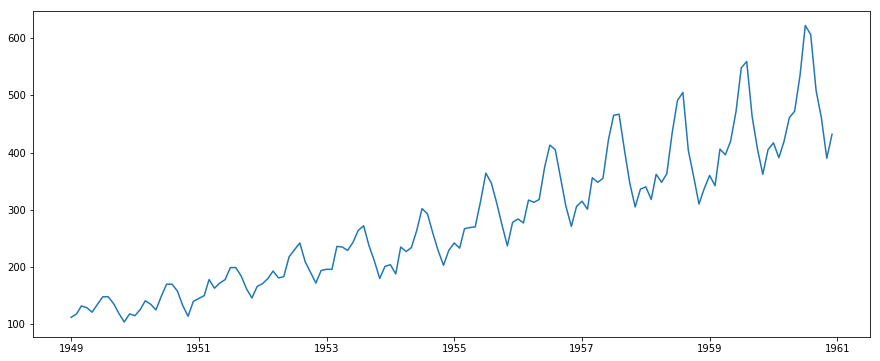

In [25]:
# visualizando os dados
plt.plot(ts)

### Análise sobre os dados
Voltando a verificar a estacionaridade, usa-se os gráficos de estatísticas contínuos juntamente com os resultados dos testes do Dickey-Fuller, por isso definiu-se uma função que recebe um TS como entrada e os gerou para nós. Observe que plotou-se o **desvio padrão** em vez da **variaça** para manter a unidade semelhante à **média**.


In [32]:
from statsmodels.tsa.stattools import adfuller
# testando a estaciona
def test_stationarity(timeseries):
    
    # Determing rolling statistics   
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    dfoutput
    

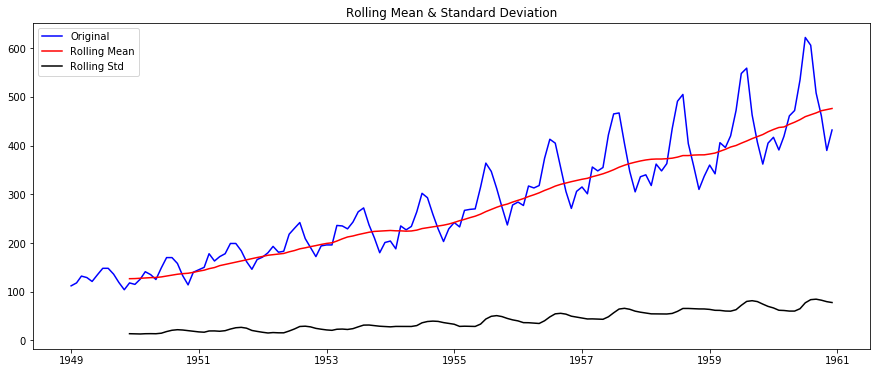

Results of Dickey-Fuller Test:


In [33]:
test_stationarity(ts)

Embora a variação no **desvio padrão** seja pequena, a **média** está claramente aumentando com o tempo e isso não é uma série estacionária. Além disso, a estatística de teste é muito mais do que os valores críticos. Observe que os valores assinados devem ser comparados e não os valores absolutos. Em seguida, discutiremos as técnicas que podem ser usadas para levar essa TS à estacionariedade.

### Como fazer uma série temporal estacionária?

Embora a suposição de estacionariedade seja tomada em muitos modelos TS, quase nenhuma das séries temporais práticas é estacionária. Então, os estatísticos descobriram maneiras de tornar as séries estacionárias, o que discutiremos agora. Na verdade, é quase impossível fazer uma série perfeitamente estacionária, mas tentamos levá-la o mais perto possível.

Vamos entender o que está tornando um TS não estacionário. Existem duas razões principais por trás do não estacionarista de um TS:
  * **Tendência :** Variando ao longo do tempo. Por exemplo, neste caso, vimos que, em média, o número de passageiros estava crescendo com o tempo.
   
  * **Sazonalidade :** Variações em intervalos de tempo específicos. Por exemplo, as pessoas podem ter a tendência de comprar carros em um determinado mês devido ao aumento de salário ou festivais. 

O princípio subjacente é modelar ou estimar a tendência e a sazonalidade da série e removê-la da série para obter uma série estacionária. Em seguida, as técnicas de previsão estatística podem ser implementadas nesta série. A etapa final seria converter os valores previstos na escala original aplicando as restrições de tendência e sazonalidade.

### Estimando & Eliminando a Tendência

Um dos primeiros truques para reduzir a tendência pode ser a transformação. Por exemplo, neste caso, podemos ver claramente que há uma tendência positiva significativa. Assim, podemos aplicar transformações que penalizam valores mais altos do que valores menores. Estes podem ser um log, raiz quadrada, raiz cúbica, etc. Vamos pegar uma transformação log aqui para simplificar:



In [35]:
ts_log = np.log(ts)

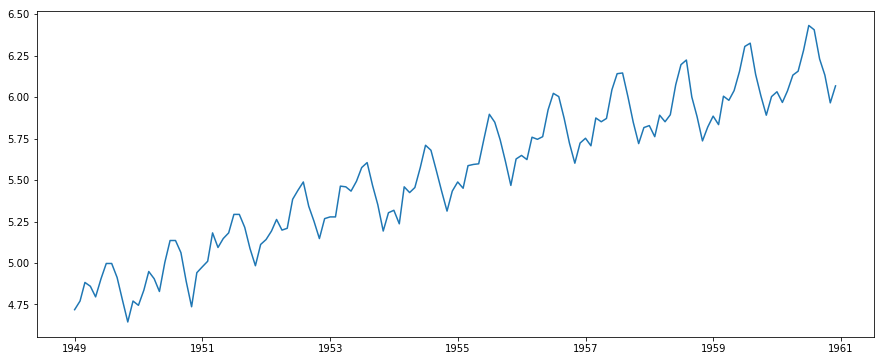

In [40]:
plt.plot(ts_log)

Neste caso mais simples, é fácil ver uma tendência de avanço nos dados. Mas não é muito intuitivo na presença de ruído. Assim, podemos usar algumas técnicas para estimar ou modelar essa tendência e, em seguida, removê-la da série. Pode haver muitas maneiras de fazer isso e algumas das mais usadas são:
  * **Agregação : ** Tomando média por um período de tempo como médias mensais / semanais.
  * **Suavinzação : ** Tendo médias rolantes.
  * **Montagem polinomial : ** Encaixar um modelo de regressão.
  
Suavização refere-se a estimativas contínuas, ou seja, considerando os últimos instantes. 

#### Média Movel

Nesta abordagem, tomamos a média de valores consecutivos de "k" dependendo da frequência das séries temporais. Aqui podemos tirar a média dos últimos 1 ano, ou seja, últimos 12 valores. Os pandas têm funções específicas definidas para determinar as estatísticas de rolagem.


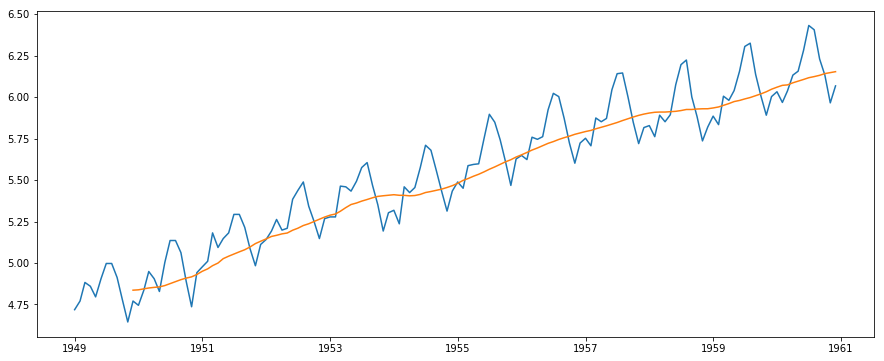

In [41]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg)

A linha vermelha mostra a média de rolamento. Vamos subtrair isso da série original. Observe que, como estamos tirando a média dos últimos 12 valores, a média de rolagem não está definida para os primeiros 11 valores. Isso pode ser observado como:


In [44]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

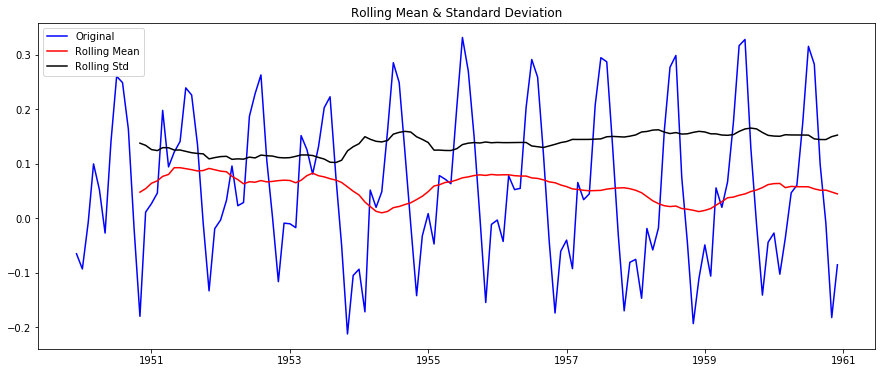

Results of Dickey-Fuller Test:


In [45]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Isto parece uma série muito melhor. Os valores de rolagem parecem estar variando um pouco, mas não há uma tendência específica. Além disso, a estatística de teste é menor que os valores críticos de 5%, portanto, podemos afirmar com 95% de confiança que essa é uma série estacionária.

No entanto, uma desvantagem nessa abordagem particular é que o período de tempo deve ser estritamente definido. Neste caso, podemos obter médias anuais, mas em situações complexas, como a previsão de um preço de ações, é difícil encontrar um número. Então, pegamos uma "média móvel ponderada", em que valores mais recentes recebem um peso maior. Pode haver muitas técnicas para atribuir pesos. Um popular é a média móvel exponencialmente ponderada, onde os pesos são atribuídos a todos os valores anteriores com um fator de decaimento. Encontre detalhes aqui. Isso pode ser implementado em Pandas como:

NotImplementedError: See issue #11704 https://github.com/pandas-dev/pandas/issues/11704

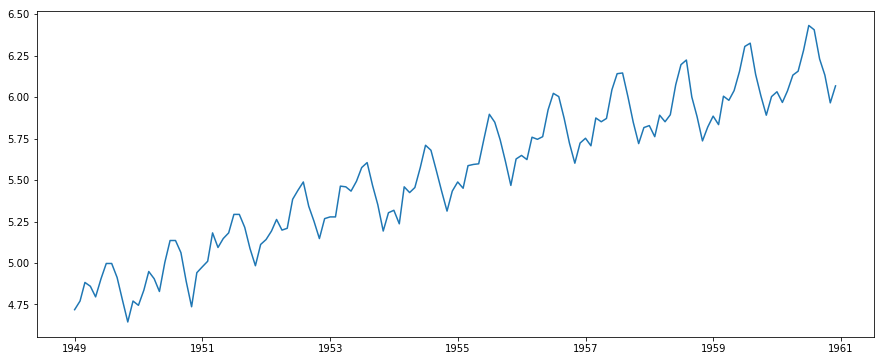

In [52]:
expwighted_avg = ts_log.ewm(halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

## Referências
   * [Analytics Vidhya : A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
   * [Dmitriy Sergeev - Medium: Open Machine Learning Course. Topic 9. Part 1. Time series analysis in Python](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3)
   * [Analytics Vidhya: A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)